/home/ariyan/Environments/anaconda3/envs/phyto3d/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


:: Found 2 clusters
:: Closest to center is [0.27513831 0.39791994]
:: Radius of cropping is 0.15753058950975626


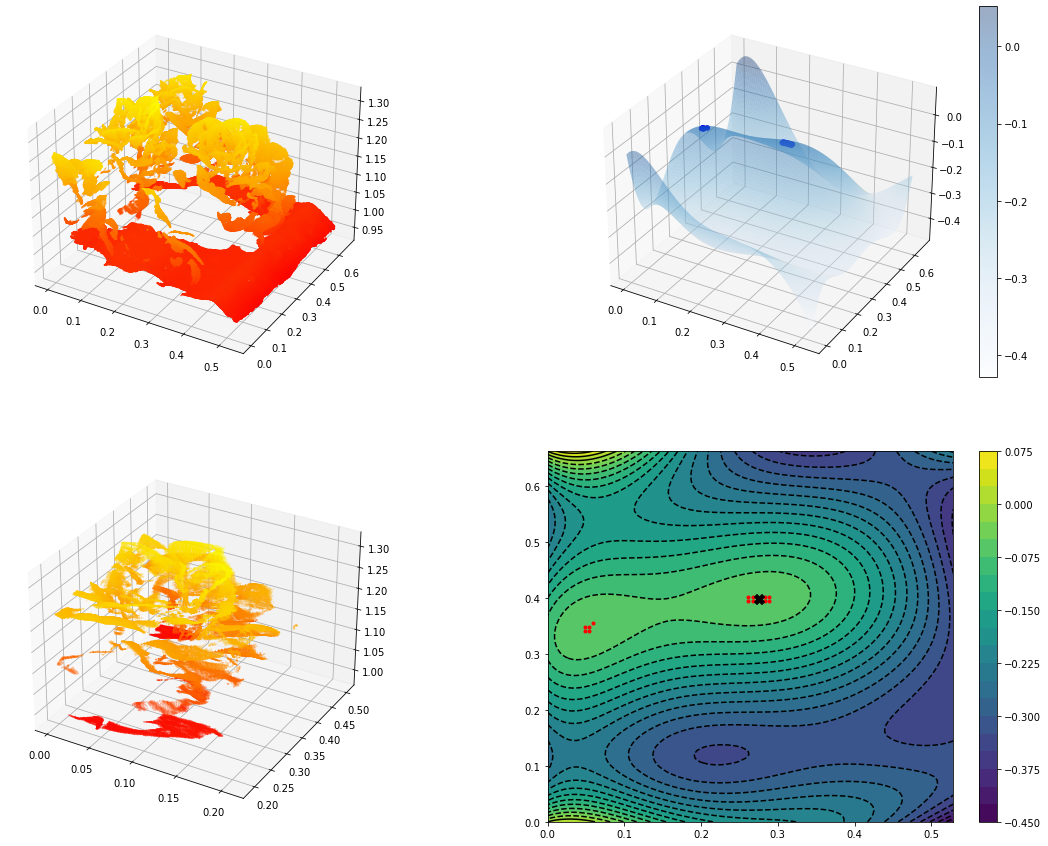

In [21]:

# !pip install sympy

from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import matplotlib.pyplot as plt
import open3d as o3d
import scipy.optimize as optimize
import numpy as np
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
from sympy import Symbol, Derivative
import sympy as sym
from sympy.utilities.lambdify import lambdify
from sklearn.cluster import AgglomerativeClustering
import math

# Variables
pcd_list = glob.glob('/media/ariyan/DATA/Data/University/IVILAB/PhytoOracle/Repositories/PlantCentering/pcds/*')
plant_choice = 3
deg_of_poly = 6
N = 100
tresh = 0.1
crop_thresh = 0.2

# preparing point cloud
pcd = o3d.io.read_point_cloud(pcd_list[plant_choice])
pcd_arr = np.asarray(pcd.points)
xmin = pcd_arr[:,0].min()
ymin = pcd_arr[:,1].min()
movement = [xmin, ymin, 0]
pcd_arr = pcd_arr - movement
X = pcd_arr[:,0:2]
Y = pcd_arr[:,-1]
datapoints = pcd_arr

# Fitting model
poly = PolynomialFeatures(degree=deg_of_poly)
X_ = poly.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X_, Y)

xmax = pcd_arr[:,0].max()
ymax = pcd_arr[:,1].max()

predict_x0, predict_x1 = np.meshgrid(np.linspace(0, xmax, N),
                                     np.linspace(0, ymax, N))

predict_x = np.concatenate((predict_x0.reshape(-1, 1), 
                            predict_x1.reshape(-1, 1)), 
                           axis=1)
predict_x_ = poly.fit_transform(predict_x)
predict_y = clf.predict(predict_x_)

coef = clf.coef_
degs = poly.get_feature_names()

# Converting to symbolic function and taking derivative
x0= Symbol('x0')
x1= Symbol('x1')

function = 0

for i,c in enumerate(coef):
    d = degs[i]
    function+=c*eval(d.replace(' ','*').replace('^','**'))

partialderiv_x0= Derivative(function, x0)
partialderiv_x1= Derivative(function, x1)

f_1 = partialderiv_x0.doit()
f_2 = partialderiv_x1.doit()

secondderivative_x0= Derivative(f_1, x0)
secondderivative_x1= Derivative(f_2, x1)
secondderivative_x0x1= Derivative(f_1, x1)

f_11 = secondderivative_x0.doit()
f_22 = secondderivative_x1.doit()
f_12 = secondderivative_x0x1.doit()

# Converting the partial derivatives to lambda function for numpy calculations
func = lambdify([x0,x1], function,'numpy') 
func1 = lambdify([x0,x1], f_1,'numpy') 
func2 = lambdify([x0,x1], f_2,'numpy') 
func11 = lambdify([x0,x1], f_11,'numpy') 
func22 = lambdify([x0,x1], f_22,'numpy') 
func12 = lambdify([x0,x1], f_12,'numpy')

y_new = func(predict_x0,predict_x1)
y_new_1 = func1(predict_x0,predict_x1)
y_new_2 = func2(predict_x0,predict_x1)
y_new_11 = func11(predict_x0,predict_x1)
y_new_22 = func22(predict_x0,predict_x1)
y_new_12 = func12(predict_x0,predict_x1)

# Finding the peaks using derivative 0.25test
D = y_new_11*y_new_22-y_new_12**2
sx20 = predict_x0[np.where((y_new_1<=tresh) & (y_new_1>=-tresh) & (y_new_2<=tresh) & (y_new_2>=-tresh) & (y_new_11<0) & (D>0))]
sx21 = predict_x1[np.where((y_new_1<=tresh) & (y_new_1>=-tresh) & (y_new_2<=tresh) & (y_new_2>=-tresh) & (y_new_11<0) & (D>0))]

# Finding clusters and centroids
data = np.array([[x,sx21[i]] for i,x in enumerate(sx20)])
clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0.1).fit(data)
labels = clustering.labels_

pcd_center = np.mean(datapoints,axis=0)

centers = []
closest_center = None
min_d = sys.maxsize

for i in range(clustering.n_clusters_):
    points = data[labels==i]
    center = np.mean(points,axis=0)
    centers.append(center)
    d = math.sqrt((center[0]-pcd_center[0])**2+(center[0]-pcd_center[0])**2)

    if closest_center is None or d<min_d:
        closest_center = center
        min_d = d

## ------- Add this -----------

next_centroid = None
next_centroid_distance = sys.maxsize

for i in range(clustering.n_clusters_):
    points = data[labels==i]
    center = np.mean(points,axis=0)
    d = math.sqrt((center[0]-closest_center[0])**2+(center[0]-closest_center[0])**2)
    if d == 0:
        continue
    
    if d<next_centroid_distance:
        next_centroid_distance = d
        next_centroid = center

if next_centroid is None:
    radius = -1
else:
    radius = next_centroid_distance/2

##----------------------------

print(f":: Found {clustering.n_clusters_} clusters")
print(f":: Closest to center is {closest_center}")
print(f":: Radius of cropping is {radius}")

# Crop around the center
mins = np.min(datapoints,axis=0)
maxs = np.max(datapoints,axis=0)

width = maxs[0]-mins[0]
length = maxs[1]-mins[1]

bound_x = crop_thresh*width
bound_y = crop_thresh*length

new_pcd_arr = pcd_arr.copy()

## ------- Add this -----------
if radius == -1:
    new_pcd_arr = new_pcd_arr[np.where((new_pcd_arr[:,0]>mins[0]+bound_x) & (new_pcd_arr[:,0]<maxs[0]-bound_x) & (new_pcd_arr[:,1]>mins[1]+bound_y) & (new_pcd_arr[:,1]<maxs[1]-bound_y))]
else:
    new_pcd_arr = new_pcd_arr[np.where(np.sqrt((new_pcd_arr[:,0]-center[0])**2 + (new_pcd_arr[:,1]-center[1])**2)<radius)]
## ----------------------------

# plotting 
z = func(sx20,sx21)

fig = plt.figure(figsize=(20, 15))

ax0 = fig.add_subplot(221, projection='3d')
ax0.scatter(pcd_arr[:,0], pcd_arr[:,1], pcd_arr[:,2], cmap=cm.autumn, c=pcd_arr[:,2], marker='.', alpha=0.4,s=0.5)

ax1 = fig.add_subplot(222, projection='3d')
surf = ax1.plot_surface(predict_x0, predict_x1, y_new, 
                        rstride=1, cstride=1, cmap=cm.Blues, alpha=0.4)
ax1.scatter(sx20, sx21, z, c='b', marker='o',alpha=1)
fig.colorbar(surf, ax=ax1)

ax2 = fig.add_subplot(223, projection='3d')
ax2.scatter(new_pcd_arr[:,0], new_pcd_arr[:,1], new_pcd_arr[:,2], cmap=cm.autumn, c=new_pcd_arr[:,2], marker='.', alpha=0.4,s=0.5)


ax3 = fig.add_subplot(224)
cs = ax3.contourf(predict_x0, predict_x1, y_new.reshape(predict_x0.shape),levels=20)
ax3.contour(cs, colors='k')
fig.colorbar(cs, ax=ax3)
ax3.scatter(sx20,sx21,c='r',marker='.')
ax3.scatter(closest_center[0],closest_center[1],c='black',marker='X',s=100)
plt.show()